<a href="https://colab.research.google.com/github/KhamessiTaha/CarVisionProject/blob/main/Car_Model_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile


train_zip_path = '/content/drive/MyDrive/batch_one/batch_one_train.zip'


extracted_train_folder = '/content/drive/MyDrive/batch_one/train'


with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_train_folder)

print("Training data extraction completed.")


In [ ]:

test_zip_path = '/content/drive/MyDrive/batch_one/batch_one_test.zip'


extracted_test_folder = '/content/drive/MyDrive/batch_one/test'


with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_test_folder)

print("Testing data extraction completed.")



Testing data extraction completed.


In [ ]:
%cd /content/drive/MyDrive/batch_one/
!ls

/content/drive/MyDrive/batch_one
 batch_one_test.zip	     model_checkpoint_best.h5	 test
 batch_one_train.zip	     model_checkpoint.h5	 train
 model2_checkpoint_best.h5  'Model Checkpoints'		 trained_model.h5
 model2_checkpoint.h5	     regularized_checkpoint.h5


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

In [ ]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/batch_one/')
print(data_dir)

/content/drive/MyDrive/batch_one


/content/drive/MyDrive/batch_one/train/images/946500.jpg


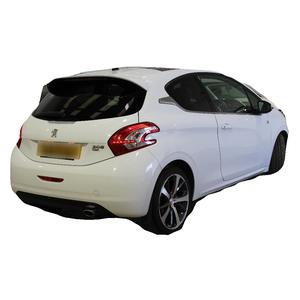

In [ ]:
cars_train = list(data_dir.glob('train/images/*'))
print(cars_train[7])
PIL.Image.open(str(cars_train[7]))

/content/drive/MyDrive/batch_one/test/images/73187.jpg


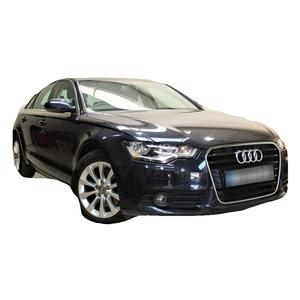

In [71]:
cars_test = list(data_dir.glob('test/images/*'))
print(cars_test[3])
PIL.Image.open(str(cars_test[3]))

In [13]:


train_labels_df = pd.read_csv('/content/drive/MyDrive/batch_one/train/train_labels.csv')
test_labels_df = pd.read_csv('/content/drive/MyDrive/batch_one/test/test_labels.csv')


train_labels_df['Year'] = train_labels_df['Year'].astype(str)
test_labels_df['Year'] = test_labels_df['Year'].astype(str)


train_labels_df['Brand'] = train_labels_df[['Make', 'Model', 'Year']].apply(lambda x: '_'.join(x), axis=1)
test_labels_df['Brand'] = test_labels_df[['Make', 'Model', 'Year']].apply(lambda x: '_'.join(x), axis=1)


train_labels_df.drop(columns=['Make', 'Model', 'Year'], inplace=True)
test_labels_df.drop(columns=['Make', 'Model', 'Year'], inplace=True)


print("Train Labels DataFrame:")
print(train_labels_df.head())
print("\nTest Labels DataFrame:")
print(test_labels_df.head())

Train Labels DataFrame:
         Image                Brand
0  1247261.jpg  Vauxhall_Corsa_2008
1   462484.jpg       Ford_Kuga_2013
2  1042043.jpg  Renault_Kadjar_2017
3   322720.jpg        Fiat_500_2008
4   949692.jpg     Peugeot_207_2008

Test Labels DataFrame:
       Image         Brand
0  14729.jpg  Audi_A1_2019
1  15731.jpg  Audi_A1_2019
2  15940.jpg  Audi_A1_2019
3  15823.jpg  Audi_A1_2019
4  15439.jpg  Audi_A1_2019


In [14]:
img_height,img_width=300,300
batch_size=32
train_aug = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    height_shift_range=0.1,
    width_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range = [1, 1.5],
    fill_mode='nearest'
)
test_aug = ImageDataGenerator(rescale=1./255)



In [15]:

col ="Brand"

train_generator = train_aug.flow_from_dataframe(
    dataframe=train_labels_df,
    directory='train/images',
    x_col='Image',
    y_col=col,
    target_size=(img_height,img_width),
    seed=42,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 32000 validated image filenames belonging to 200 classes.


In [16]:


test_generator = test_aug.flow_from_dataframe(
    dataframe=test_labels_df,
    directory='test/images',
    x_col='Image',
    y_col=col,
    target_size=(img_height,img_width),
    seed=42,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 7229 validated image filenames belonging to 200 classes.


In [18]:
class_names = train_labels_df['Brand'].unique()
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(class_names)


Number of classes: 200
['Vauxhall_Corsa_2008' 'Ford_Kuga_2013' 'Renault_Kadjar_2017'
 'Fiat_500_2008' 'Peugeot_207_2008' 'Vauxhall_Mokka_2015'
 'Ford_Focus_2008' 'SEAT_Ibiza_2011' 'Honda_CR-V_2012'
 'Vauxhall_Astra_2006' 'Land Rover_Range Rover_2015' 'Ford_Focus_2015'
 'BMW_X5_2016' 'Ford_Fiesta_2005' 'Vauxhall_Insignia_2011' 'BMW_X5_2005'
 'Ford_Kuga_2014' 'Jaguar_X-Type_2009' 'Nissan_Qashqai_2015'
 'Vauxhall_Mokka_2014' 'Ford_Mondeo_2011' 'Ford_Fiesta_2017'
 'Toyota_Auris_2015' 'Vauxhall_Corsa_2018' 'Ford_Focus_2010'
 'Vauxhall_Insignia_2015' 'Vauxhall_Corsa_2016' 'Jaguar_XF_2014'
 'Nissan_Qashqai_2012' 'Renault_Clio_2010' 'Vauxhall_Zafira Tourer_2017'
 'Vauxhall_Astra_2015' 'Vauxhall_Corsa_2012' 'Volkswagen_Golf_2017'
 'Jaguar_XF_2012' 'Audi_A3_2005' 'Audi_A4_2012' 'Fiat_Punto Evo_2010'
 'Ford_Ka_2015' 'BMW_1 Series_2019' 'BMW_X5_2007' 'Citroen_DS3_2014'
 'BMW_X5_2010' 'Volkswagen_Passat_2015' 'Ford_Ka_2010'
 'Volkswagen_Polo_2006' 'Ford_Ka_2009' 'Citroen_C3_2019'
 'Mazda_Mazda3_201

In [19]:
import matplotlib.pyplot as plt

#Training The Model

In [ ]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50V2(
                   include_top=False,
                   input_shape=(300,300,3),
                   pooling='avg',
                   classes=200,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(200, activation='softmax'))

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 module_wrapper (ModuleWrap  (None, 2048)              0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 512)               1049088   
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 200)               102600    
 apper)                                                          
                                                                 
Total params: 24716488 (94.29 MB)
Trainable params: 1151688 (4.39 MB)
Non-trainable params: 23564800 (89.89 MB)
__________

In [ ]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = '/content/drive/MyDrive/batch_one/model_checkpoint.h5'
best_checkpoint_filepath = '/content/drive/MyDrive/batch_one/model_checkpoint_best.h5'

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      save_freq=100)

best_checkpoint_callback = ModelCheckpoint(filepath=best_checkpoint_filepath,
                                           save_weights_only=True,
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [ ]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = resnet_model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=5,
                    validation_data=test_generator,
                    validation_steps=len(test_generator),
                    callbacks=[checkpoint_callback, best_checkpoint_callback])

Epoch 1/5
1000/1000 [==============================] - 18799s 19s/step - loss: 2.6527 - accuracy: 0.3064 - val_loss: 2.8574 - val_accuracy: 0.2631
Epoch 2/5
1000/1000 [==============================] - 3237s 3s/step - loss: 2.5610 - accuracy: 0.3213 - val_loss: 2.8338 - val_accuracy: 0.2722
Epoch 3/5
1000/1000 [==============================] - 3260s 3s/step - loss: 2.4985 - accuracy: 0.3314 - val_loss: 2.8281 - val_accuracy: 0.2771
Epoch 4/5
1000/1000 [==============================] - 3262s 3s/step - loss: 2.4390 - accuracy: 0.3431 - val_loss: 2.7092 - val_accuracy: 0.2927
Epoch 5/5
1000/1000 [==============================] - 3233s 3s/step - loss: 2.3747 - accuracy: 0.3571 - val_loss: 2.7790 - val_accuracy: 0.2771


In [ ]:
from keras.models import load_model

resnet_model.load_weights('/content/drive/MyDrive/batch_one/model_checkpoint.h5')


In [ ]:
fig1 = plt.gcf()

if 'accuracy' in history.history and 'val_accuracy' in history.history:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])


    plt.ylim([0.0, 1.0])


    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')


    plt.legend(['Training', 'Validation'])


    plt.show()
else:
    print("No accuracy data found in history object.")


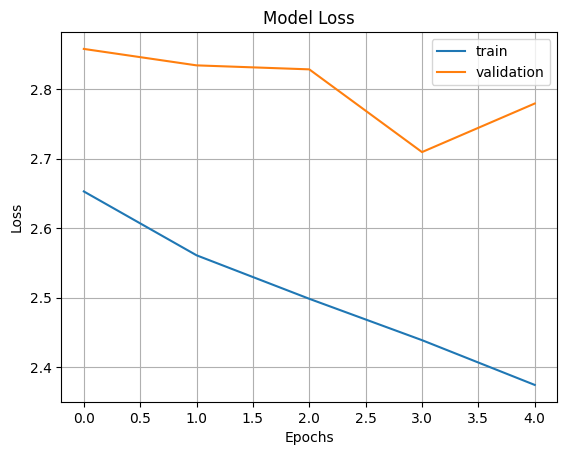

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#Making Predictions

In [ ]:
import cv2
image=cv2.imread(str(cars_test[4089]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

(1, 300, 300, 3)


In [ ]:
pred=resnet_model.predict(image)
print(pred)

1/1 [==============================] - 4s 4s/step
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+0

In [ ]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is Saab_9-3_2008


#Fine Tuning I

In [ ]:
for layer in pretrained_model.layers[:-10]:
    layer.trainable = True

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 module_wrapper (ModuleWrap  (None, 2048)              0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 512)               1049088   
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 200)               102600    
 apper)                                                          
                                                                 
Total params: 24716488 (94.29 MB)
Trainable params: 21256008 (81.09 MB)
Non-trainable params: 3460480 (13.20 MB)
_________

In [ ]:
new_learning_rate = 0.0001

In [ ]:
resnet_model.compile(optimizer=Adam(lr=new_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_fine_tune = resnet_model.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=11,
                                      validation_data=test_generator,
                                      validation_steps=len(test_generator),
                                      callbacks=[checkpoint_callback, best_checkpoint_callback])


Epoch 1/11
1000/1000 [==============================] - 34524s 35s/step - loss: 2.2631 - accuracy: 0.3658 - val_loss: 2.1313 - val_accuracy: 0.3841
Epoch 2/11
1000/1000 [==============================] - 1265s 1s/step - loss: 1.6335 - accuracy: 0.4854 - val_loss: 1.9597 - val_accuracy: 0.4165
Epoch 3/11
1000/1000 [==============================] - 1254s 1s/step - loss: 1.4141 - accuracy: 0.5319 - val_loss: 1.8562 - val_accuracy: 0.4410
Epoch 4/11
1000/1000 [==============================] - 1251s 1s/step - loss: 1.2818 - accuracy: 0.5645 - val_loss: 1.6813 - val_accuracy: 0.4724
Epoch 5/11
1000/1000 [==============================] - 1252s 1s/step - loss: 1.1716 - accuracy: 0.5944 - val_loss: 1.7287 - val_accuracy: 0.4771
Epoch 6/11
1000/1000 [==============================] - 1274s 1s/step - loss: 1.0849 - accuracy: 0.6151 - val_loss: 1.7113 - val_accuracy: 0.4713
Epoch 7/11
1000/1000 [==============================] - 1247s 1s/step - loss: 1.0232 - accuracy: 0.6314 - val_loss: 1.6931

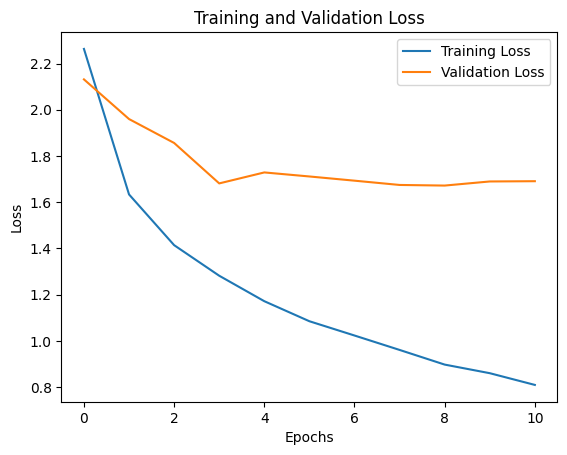

In [ ]:
plt.plot(history_fine_tune.history['loss'], label='Training Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


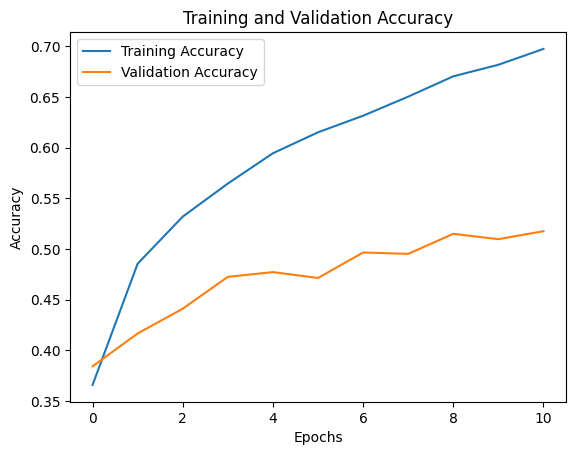

In [ ]:
plt.plot(history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
history_fine_tune = resnet_model.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=4,
                                      validation_data=test_generator,
                                      validation_steps=len(test_generator),
                                      callbacks=[checkpoint_callback, best_checkpoint_callback])

In [ ]:
history_fine_tune = resnet_model.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=4,
                                      validation_data=test_generator,
                                      validation_steps=len(test_generator),
                                      callbacks=[checkpoint_callback, best_checkpoint_callback])

Epoch 1/4
1000/1000 [==============================] - 1299s 1s/step - loss: 0.6374 - accuracy: 0.7600 - val_loss: 1.6729 - val_accuracy: 0.5392
Epoch 2/4
1000/1000 [==============================] - 1285s 1s/step - loss: 0.6067 - accuracy: 0.7721 - val_loss: 2.3568 - val_accuracy: 0.4572
Epoch 3/4
1000/1000 [==============================] - 1266s 1s/step - loss: 0.5748 - accuracy: 0.7822 - val_loss: 1.8335 - val_accuracy: 0.5482
Epoch 4/4
1000/1000 [==============================] - 1270s 1s/step - loss: 0.5496 - accuracy: 0.7931 - val_loss: 1.7930 - val_accuracy: 0.5497


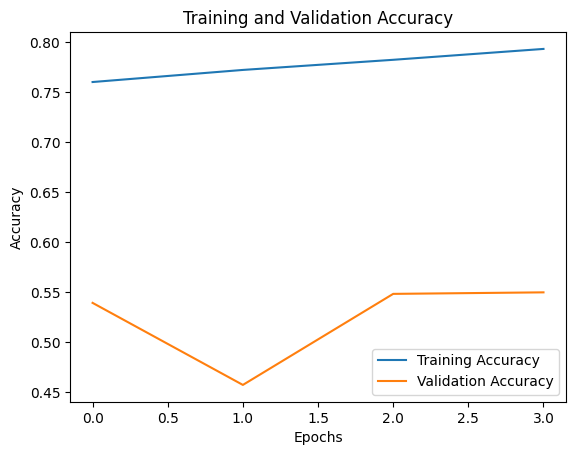

In [ ]:
plt.plot(history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
history_fine_tune= resnet_model.load_weights('/content/drive/MyDrive/batch_one/model_checkpoint.h5')

#Fine Tuning II

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50V2

In [48]:
resnet_model_2 = Sequential()

In [49]:
Resnet = ResNet50V2(
    include_top=False,
    input_shape=(300, 300, 3),
    pooling='avg',
    weights='imagenet'
)

In [50]:
for layer in Resnet.layers:
    layer.trainable = False

In [51]:
for layer in Resnet.layers[:-20]:
    layer.trainable = True

In [52]:
for layer in Resnet.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [53]:
resnet_model_2.add(Resnet)
resnet_model_2.add(Flatten())
resnet_model_2.add(Dense(1024, activation='relu'))
resnet_model_2.add(Dropout(0.5))
resnet_model_2.add(Dense(512, activation='relu'))
resnet_model_2.add(Dense(200, activation='softmax'))

In [54]:
resnet_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dense_4 (Dense)             (None, 200)               102600    
                                                                 
Total params: 26290376 (100.29 MB)
Trainable params: 1

In [66]:
resnet_model_2.load_weights('/content/drive/MyDrive/batch_one/model2_checkpoint_best.h5')

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint_filepath_2 = '/content/drive/MyDrive/batch_one/model2_checkpoint.h5'
best_checkpoint_filepath_2 = '/content/drive/MyDrive/batch_one/model2_checkpoint_best.h5'

checkpoint_callback_2 = ModelCheckpoint(filepath=checkpoint_filepath_2,
                                      save_weights_only=True,
                                      save_freq=100)

best_checkpoint_callback_2 = ModelCheckpoint(filepath=best_checkpoint_filepath_2,
                                           save_weights_only=True,
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [67]:
evaluation = resnet_model_2.evaluate(test_generator)

loss = evaluation[0]
accuracy = evaluation[1]

print("Loss:", loss)
print("Accuracy:", accuracy)

226/226 [==============================] - 49s 204ms/step - loss: 1.1955 - accuracy: 0.6131
Loss: 1.1954885721206665
Accuracy: 0.6130861639976501


In [57]:
resnet_model_2.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history_fine_tune_2 = resnet_model_2.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=11,
                                      validation_data=test_generator,
                                      validation_steps=len(test_generator),
                                      callbacks=[checkpoint_callback_2, best_checkpoint_callback_2])

Epoch 1/11
1000/1000 [==============================] - 15877s 16s/step - loss: 5.1505 - accuracy: 0.0160 - val_loss: 4.4247 - val_accuracy: 0.0588
Epoch 2/11
1000/1000 [==============================] - 1208s 1s/step - loss: 3.7455 - accuracy: 0.1145 - val_loss: 3.0350 - val_accuracy: 0.2031
Epoch 3/11
1000/1000 [==============================] - 1221s 1s/step - loss: 2.5806 - accuracy: 0.2668 - val_loss: 2.1940 - val_accuracy: 0.3211
Epoch 4/11
1000/1000 [==============================] - 1177s 1s/step - loss: 2.0222 - accuracy: 0.3679 - val_loss: 1.8287 - val_accuracy: 0.4079
Epoch 5/11
1000/1000 [==============================] - 1174s 1s/step - loss: 1.7195 - accuracy: 0.4317 - val_loss: 1.5384 - val_accuracy: 0.4652
Epoch 6/11
1000/1000 [==============================] - 1167s 1s/step - loss: 1.5236 - accuracy: 0.4735 - val_loss: 1.6347 - val_accuracy: 0.4572
Epoch 7/11
1000/1000 [==============================] - 1174s 1s/step - loss: 1.3980 - accuracy: 0.5096 - val_loss: 1.4584

In [ ]:
history_fine_tune_2 = resnet_model_2.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=11,
                                      validation_data=test_generator,
                                      validation_steps=len(test_generator),
                                      callbacks=[checkpoint_callback_2, best_checkpoint_callback_2])

Epoch 1/11
1000/1000 [==============================] - 1280s 1s/step - loss: 1.0809 - accuracy: 0.5942 - val_loss: 1.2718 - val_accuracy: 0.5531
Epoch 2/11
1000/1000 [==============================] - 1223s 1s/step - loss: 1.0369 - accuracy: 0.6083 - val_loss: 1.2423 - val_accuracy: 0.5478
Epoch 3/11
1000/1000 [==============================] - 1213s 1s/step - loss: 1.0039 - accuracy: 0.6162 - val_loss: 1.2970 - val_accuracy: 0.5554
Epoch 4/11
1000/1000 [==============================] - 1210s 1s/step - loss: 0.9662 - accuracy: 0.6283 - val_loss: 1.2536 - val_accuracy: 0.5514
Epoch 5/11
1000/1000 [==============================] - 1211s 1s/step - loss: 0.9367 - accuracy: 0.6381 - val_loss: 1.2917 - val_accuracy: 0.5569
Epoch 6/11
1000/1000 [==============================] - 1220s 1s/step - loss: 0.9089 - accuracy: 0.6477 - val_loss: 1.2668 - val_accuracy: 0.5528
Epoch 7/11
1000/1000 [==============================] - 1195s 1s/step - loss: 0.8755 - accuracy: 0.6587 - val_loss: 1.2134 -

In [ ]:
history_fine_tune_2 = resnet_model_2.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=5,
                                      validation_data=test_generator,
                                      validation_steps=len(test_generator),
                                      callbacks=[checkpoint_callback_2, best_checkpoint_callback_2])

Epoch 1/5
1000/1000 [==============================] - 1218s 1s/step - loss: 0.6799 - accuracy: 0.7325 - val_loss: 1.3795 - val_accuracy: 0.5684
Epoch 2/5
1000/1000 [==============================] - 1212s 1s/step - loss: 0.6743 - accuracy: 0.7332 - val_loss: 1.2382 - val_accuracy: 0.6040
Epoch 3/5
1000/1000 [==============================] - 1234s 1s/step - loss: 0.6446 - accuracy: 0.7466 - val_loss: 1.3096 - val_accuracy: 0.5951
Epoch 4/5
1000/1000 [==============================] - 1198s 1s/step - loss: 0.6390 - accuracy: 0.7497 - val_loss: 1.2810 - val_accuracy: 0.5999
Epoch 5/5
1000/1000 [==============================] - 1249s 1s/step - loss: 0.6186 - accuracy: 0.7582 - val_loss: 1.3261 - val_accuracy: 0.5928


In [ ]:
history_fine_tune_2 = resnet_model_2.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=5,
                                      validation_data=test_generator,
                                      validation_steps=len(test_generator),
                                      callbacks=[checkpoint_callback_2, best_checkpoint_callback_2])

Epoch 1/5
1000/1000 [==============================] - 1199s 1s/step - loss: 0.6099 - accuracy: 0.7608 - val_loss: 1.3503 - val_accuracy: 0.6073
Epoch 2/5
1000/1000 [==============================] - 1223s 1s/step - loss: 0.5865 - accuracy: 0.7675 - val_loss: 1.3512 - val_accuracy: 0.5988
Epoch 3/5
1000/1000 [==============================] - 1184s 1s/step - loss: 0.5705 - accuracy: 0.7735 - val_loss: 1.5574 - val_accuracy: 0.5720
Epoch 4/5
1000/1000 [==============================] - 1190s 1s/step - loss: 0.5695 - accuracy: 0.7769 - val_loss: 1.2918 - val_accuracy: 0.6103
Epoch 5/5
1000/1000 [==============================] - 1184s 1s/step - loss: 0.5431 - accuracy: 0.7895 - val_loss: 1.3570 - val_accuracy: 0.6077


In [ ]:
history_fine_tune_2 = resnet_model_2.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=5,
                                      validation_data=test_generator,
                                      validation_steps=len(test_generator),
                                      callbacks=[checkpoint_callback_2, best_checkpoint_callback_2])

Epoch 1/5
1000/1000 [==============================] - 1195s 1s/step - loss: 0.5358 - accuracy: 0.7906 - val_loss: 1.4276 - val_accuracy: 0.5951
Epoch 2/5
1000/1000 [==============================] - 1209s 1s/step - loss: 0.5192 - accuracy: 0.7985 - val_loss: 1.5459 - val_accuracy: 0.5853
Epoch 3/5
1000/1000 [==============================] - 1203s 1s/step - loss: 0.5174 - accuracy: 0.7991 - val_loss: 1.5373 - val_accuracy: 0.5803
Epoch 4/5
1000/1000 [==============================] - 1254s 1s/step - loss: 0.4942 - accuracy: 0.8086 - val_loss: 1.5402 - val_accuracy: 0.5969
Epoch 5/5
1000/1000 [==============================] - 1210s 1s/step - loss: 0.4814 - accuracy: 0.8156 - val_loss: 1.5744 - val_accuracy: 0.5886


In [ ]:
history_fine_tune_2 = resnet_model_2.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=5,
                                      validation_data=test_generator,
                                      validation_steps=len(test_generator),
                                      callbacks=[checkpoint_callback_2, best_checkpoint_callback_2])

Epoch 1/5
1000/1000 [==============================] - 1202s 1s/step - loss: 0.4765 - accuracy: 0.8170 - val_loss: 1.4295 - val_accuracy: 0.6117
Epoch 2/5
1000/1000 [==============================] - 1197s 1s/step - loss: 0.4633 - accuracy: 0.8243 - val_loss: 1.6238 - val_accuracy: 0.5839
Epoch 3/5
1000/1000 [==============================] - 1186s 1s/step - loss: 0.4509 - accuracy: 0.8273 - val_loss: 1.5300 - val_accuracy: 0.5912
Epoch 4/5
1000/1000 [==============================] - 1197s 1s/step - loss: 0.4420 - accuracy: 0.8341 - val_loss: 1.5106 - val_accuracy: 0.6128
Epoch 5/5
1000/1000 [==============================] - 1200s 1s/step - loss: 0.4236 - accuracy: 0.8388 - val_loss: 1.7168 - val_accuracy: 0.5851


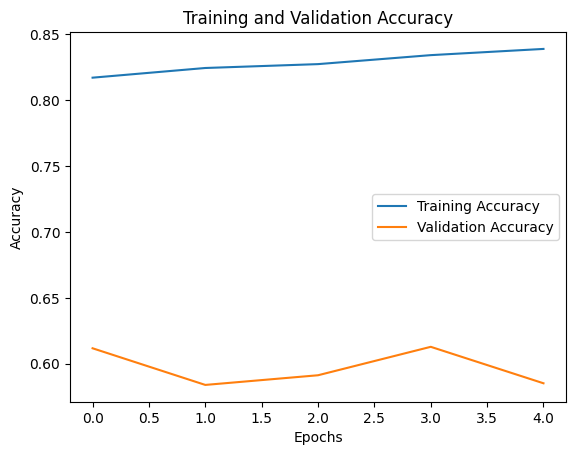

In [ ]:
plt.plot(history_fine_tune_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tune_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

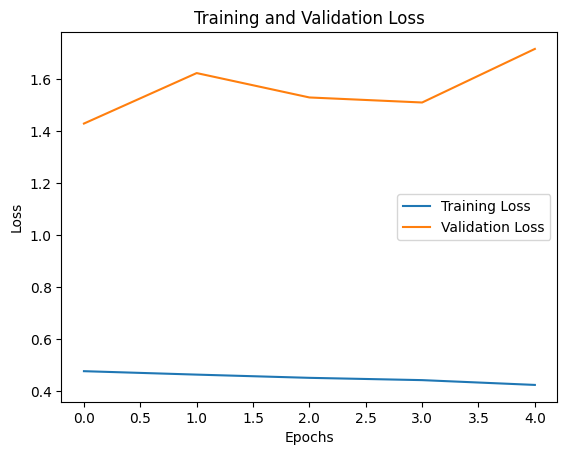

In [ ]:
plt.plot(history_fine_tune_2.history['loss'], label='Training Loss')
plt.plot(history_fine_tune_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Make Predictions with the fine-tuned Model  

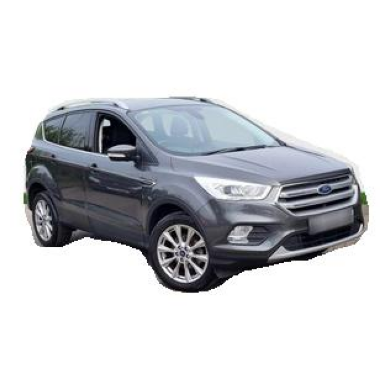

(1, 300, 300, 3)


In [ ]:
import cv2
image=cv2.imread(str(cars_train[9832]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
print(image.shape)

In [ ]:
pred=resnet_model_2.predict(image)
print(pred)

1/1 [==============================] - 0s 36ms/step
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e

In [ ]:
possible_classes = []
predicted_index = np.argmax(pred)
for i, class_name in enumerate(class_names):
    if i == predicted_index:
        print("The predicted class is", class_name)
    possible_classes.append(class_name)
print("All possible classes:", possible_classes)


The predicted class is Fiat_Punto Evo_2010
All possible classes: ['Vauxhall_Corsa_2008', 'Ford_Kuga_2013', 'Renault_Kadjar_2017', 'Fiat_500_2008', 'Peugeot_207_2008', 'Vauxhall_Mokka_2015', 'Ford_Focus_2008', 'SEAT_Ibiza_2011', 'Honda_CR-V_2012', 'Vauxhall_Astra_2006', 'Land Rover_Range Rover_2015', 'Ford_Focus_2015', 'BMW_X5_2016', 'Ford_Fiesta_2005', 'Vauxhall_Insignia_2011', 'BMW_X5_2005', 'Ford_Kuga_2014', 'Jaguar_X-Type_2009', 'Nissan_Qashqai_2015', 'Vauxhall_Mokka_2014', 'Ford_Mondeo_2011', 'Ford_Fiesta_2017', 'Toyota_Auris_2015', 'Vauxhall_Corsa_2018', 'Ford_Focus_2010', 'Vauxhall_Insignia_2015', 'Vauxhall_Corsa_2016', 'Jaguar_XF_2014', 'Nissan_Qashqai_2012', 'Renault_Clio_2010', 'Vauxhall_Zafira Tourer_2017', 'Vauxhall_Astra_2015', 'Vauxhall_Corsa_2012', 'Volkswagen_Golf_2017', 'Jaguar_XF_2012', 'Audi_A3_2005', 'Audi_A4_2012', 'Fiat_Punto Evo_2010', 'Ford_Ka_2015', 'BMW_1 Series_2019', 'BMW_X5_2007', 'Citroen_DS3_2014', 'BMW_X5_2010', 'Volkswagen_Passat_2015', 'Ford_Ka_2010', '

#Regularization (BatchNormalization and L1/L2 Regularization)

In [25]:
from keras.regularizers import l1, l2
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50V2


In [26]:
Resnet = ResNet50V2(
    include_top=False,
    input_shape=(300, 300, 3),
    classes=200,
    weights='imagenet'
)
for layer in Resnet.layers:
    layer.trainable = True



94668760/94668760 [==============================] - 0s 0us/step


In [27]:
Final_Model = Sequential()


In [28]:
Final_Model.add(Resnet)
Final_Model.add(GlobalAveragePooling2D(data_format='channels_last', name='head_gap'))
Final_Model.add(Dense(512, activation='relu', kernel_regularizer=l1(0.01)))
Final_Model.add(BatchNormalization())
Final_Model.add(Dropout(0.5))
Final_Model.add(Dense(200, activation='softmax', kernel_regularizer=l2(0.01)))

In [29]:
Final_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 10, 10, 2048)      23564800  
                                                                 
 head_gap (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 200)              

In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [31]:
Final_Model.compile(optimizer=Adam(0.0001),
                       loss='categorical_crossentropy',
                       metrics=["categorical_accuracy"])

In [32]:
checkpoint_callback_Final = ModelCheckpoint('/content/drive/MyDrive/batch_one/regularized_checkpoint.h5',
                                        monitor='val_loss',
                                        save_best_only=True,
                                        mode='min',
                                        verbose=1)

In [33]:
early_stopping_callback_2 = EarlyStopping(monitor='val_loss',
                                         patience=5,
                                         min_delta=0,
                                         restore_best_weights=True,
                                         verbose=1)

In [ ]:
history_Regularization = Final_Model.fit(train_generator,
                                         steps_per_epoch=len(train_generator),
                                         epochs=30,
                                         validation_data=test_generator,
                                         validation_steps=len(test_generator),
                                         callbacks=[checkpoint_callback_Final, early_stopping_callback_2])

Resume Training

In [ ]:
from keras.models import load_model
Final_Model=load_model('/content/drive/MyDrive/batch_one/regularized_checkpoint.h5')
Final_Model.compile(optimizer=Adam(0.0001),
                       loss='categorical_crossentropy',
                       metrics=["categorical_accuracy"])
history_Regularization = Final_Model.fit(train_generator,
                                         steps_per_epoch=len(train_generator),
                                         epochs=5,
                                         validation_data=test_generator,
                                         validation_steps=len(test_generator),
                                         callbacks=[checkpoint_callback_Final, early_stopping_callback_2])

Epoch 1/5
1000/1000 [==============================] - ETA: 0s - loss: 2.6459 - categorical_accuracy: 0.5360 
Epoch 1: val_loss improved from inf to 2.53632, saving model to /content/drive/MyDrive/batch_one/regularized_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - 17549s 18s/step - loss: 2.6459 - categorical_accuracy: 0.5360 - val_loss: 2.5363 - val_categorical_accuracy: 0.5226
Epoch 2/5
1000/1000 [==============================] - ETA: 0s - loss: 2.4740 - categorical_accuracy: 0.5515
Epoch 2: val_loss improved from 2.53632 to 2.52249, saving model to /content/drive/MyDrive/batch_one/regularized_checkpoint.h5
1000/1000 [==============================] - 820s 820ms/step - loss: 2.4740 - categorical_accuracy: 0.5515 - val_loss: 2.5225 - val_categorical_accuracy: 0.5265
Epoch 3/5
1000/1000 [==============================] - ETA: 0s - loss: 2.3353 - categorical_accuracy: 0.5702
Epoch 3: val_loss improved from 2.52249 to 2.34749, saving model to /content/drive/MyDrive/batch_one/regularized_checkpoint.h5
1000/1000 [==============================] - 820s 819ms/step - loss: 2.3353 - categorical_accuracy: 0.5702 - val_loss: 2.3475 - val_categorical_accuracy: 0.5412
Epoch 4/5
1000/1000 [========================

In [ ]:
model_save_path = '/content/drive/MyDrive/batch_one/trained_model.h5'
Final_Model.save(model_save_path)
print("Model saved successfully at:", model_save_path)

Model saved successfully at: /content/drive/MyDrive/batch_one/trained_model.h5


In [ ]:
from keras.models import load_model
Final_Model=load_model('/content/drive/MyDrive/batch_one/regularized_checkpoint.h5')
Final_Model.compile(optimizer=Adam(0.0001),
                       loss='categorical_crossentropy',
                       metrics=["categorical_accuracy"])
history_Regularization = Final_Model.fit(train_generator,
                                         steps_per_epoch=len(train_generator),
                                         epochs=20,
                                         validation_data=test_generator,
                                         validation_steps=len(test_generator),
                                         callbacks=[checkpoint_callback_Final, early_stopping_callback_2])

Epoch 1/20
1000/1000 [==============================] - ETA: 0s - loss: 2.0740 - categorical_accuracy: 0.6110 
Epoch 1: val_loss improved from inf to 2.25488, saving model to /content/drive/MyDrive/batch_one/regularized_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - 17339s 17s/step - loss: 2.0740 - categorical_accuracy: 0.6110 - val_loss: 2.2549 - val_categorical_accuracy: 0.5481
Epoch 2/20
 501/1000 [==============>...............] - ETA: 6:41 - loss: 1.9771 - categorical_accuracy: 0.6299

In [35]:
from keras.models import load_model
Final_Model=load_model('/content/drive/MyDrive/batch_one/regularized_checkpoint.h5')
Final_Model.compile(optimizer=Adam(0.0001),
                       loss='categorical_crossentropy',
                       metrics=["categorical_accuracy"])
history_Regularization = Final_Model.fit(train_generator,
                                         steps_per_epoch=len(train_generator),
                                         epochs=20,
                                         validation_data=test_generator,
                                         validation_steps=len(test_generator),
                                         callbacks=[checkpoint_callback_Final, early_stopping_callback_2])

Epoch 1/20
1000/1000 [==============================] - ETA: 0s - loss: 1.9805 - categorical_accuracy: 0.6296 
Epoch 1: val_loss improved from inf to 2.17860, saving model to /content/drive/MyDrive/batch_one/regularized_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - 16130s 16s/step - loss: 1.9805 - categorical_accuracy: 0.6296 - val_loss: 2.1786 - val_categorical_accuracy: 0.5596
Epoch 2/20
1000/1000 [==============================] - ETA: 0s - loss: 1.9311 - categorical_accuracy: 0.6358
Epoch 2: val_loss improved from 2.17860 to 2.14367, saving model to /content/drive/MyDrive/batch_one/regularized_checkpoint.h5
1000/1000 [==============================] - 1208s 1s/step - loss: 1.9311 - categorical_accuracy: 0.6358 - val_loss: 2.1437 - val_categorical_accuracy: 0.5659
Epoch 3/20
1000/1000 [==============================] - ETA: 0s - loss: 1.8742 - categorical_accuracy: 0.6449
Epoch 3: val_loss did not improve from 2.14367
1000/1000 [==============================] - 1193s 1s/step - loss: 1.8742 - categorical_accuracy: 0.6449 - val_loss: 2.2923 - val_categorical_accuracy: 0.5418
Epoch 4/20
1000/1000 [==============================] - ETA: 0s - loss: 1.8081 - categorical_accuracy: 0.6574
Epoch 4: val_loss

In [39]:
model_save_path = '/content/drive/MyDrive/batch_one/trained_model.h5'
Final_Model.save(model_save_path)
print("Model saved successfully at:", model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully at: /content/drive/MyDrive/batch_one/trained_model.h5


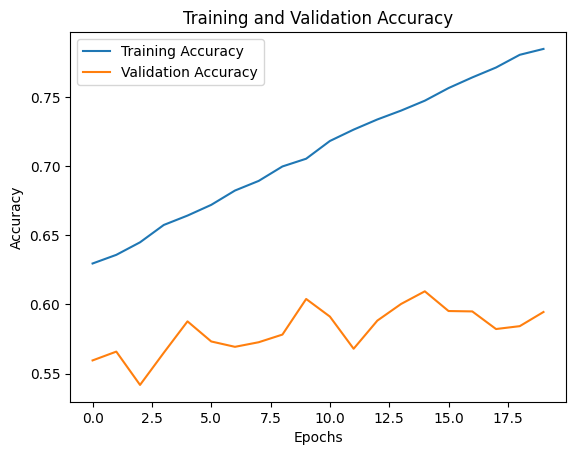

In [42]:
plt.plot(history_Regularization.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history_Regularization.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

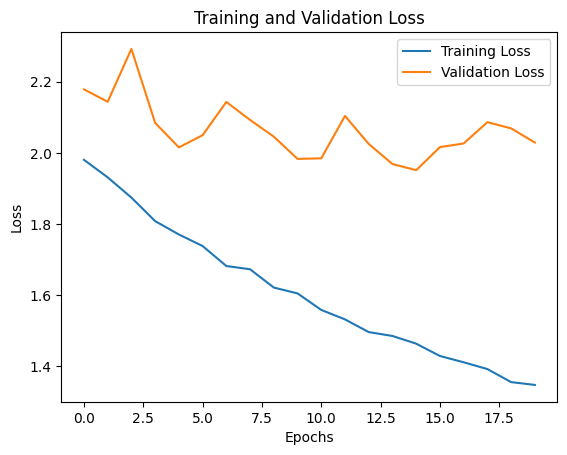

In [43]:
plt.plot(history_Regularization.history['loss'], label='Training Loss')
plt.plot(history_Regularization.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
evaluation = Final_Model.evaluate(test_generator)

loss = evaluation[0]
accuracy = evaluation[1]

print("Loss:", loss)
print("Accuracy:", accuracy)

226/226 [==============================] - 55s 244ms/step - loss: 1.9513 - categorical_accuracy: 0.6095
Loss: 1.9513353109359741
Accuracy: 0.6094895601272583


#Making Prediction With Our Final Model

/content/drive/MyDrive/batch_one/test/images/73187.jpg


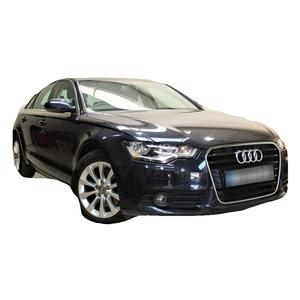

In [102]:
cars_test = list(data_dir.glob('test/images/*'))
print(cars_test[3])
PIL.Image.open(str(cars_test[3]))

In [103]:
import cv2
image=cv2.imread(str(cars_test[3]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

(1, 300, 300, 3)


In [104]:
pred=Final_Model.predict(image)
print(pred)

1/1 [==============================] - 0s 37ms/step
[[2.91380887e-25 2.26754956e-37 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.06074348e-28 0.00000000e+00
  1.99532236e-27 2.08361853e-05 1.47247988e-23 8.06609761e-38
  2.11944377e-28 1.53982563e-20 4.60546031e-35 7.28108932e-21
  1.77095113e-26 0.00000000e+00 0.00000000e+00 2.67152243e-28
  2.26511548e-26 5.49670978e-19 9.22444832e-19 1.33788931e-21
  6.52952374e-26 6.05423647e-24 8.27646823e-28 0.00000000e+00
  9.98600560e-18 1.14848033e-08 1.12525634e-25 3.03409504e-23
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 7.85370102e-10 2.55346288e-16
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.53757236e-27 4.54673183e-15 5.66874134e-22
  4.44986144e-26 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0

In [105]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is Audi_A6 Saloon_2013


Saving 3.jpg to 3 (2).jpg
Image shape: (1, 300, 300, 3)
1/1 [==============================] - 0s 38ms/step
Predicted probabilities: [[1.3226431e-28 2.7479473e-32 1.0663384e-37 4.3427261e-34 4.4823485e-38
  5.7423350e-38 7.8664729e-29 0.0000000e+00 2.9644685e-25 3.3566815e-12
  3.5858699e-26 2.2098869e-36 9.5505161e-28 5.0320081e-25 1.1666958e-33
  4.1934397e-27 8.2391861e-28 3.2194378e-38 0.0000000e+00 1.2056487e-23
  9.3709716e-21 7.3115143e-16 1.2693797e-14 6.8355381e-18 8.2931955e-22
  2.8890888e-17 8.2587167e-23 0.0000000e+00 3.8787595e-18 1.3674085e-09
  3.2867008e-27 1.2259411e-27 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 4.1805119e-30 1.0885143e-09 7.4584978e-19
  1.3054616e-33 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.7484401e-26 2.2406063e-14
  1.5626363e-17 6.2625440e-21 0.0000000e+00 5.5269678e-37 0.0000000e+00
  8

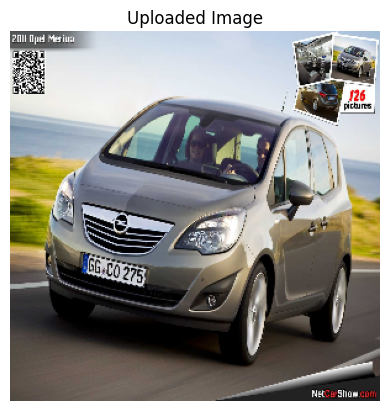

In [110]:
import matplotlib.pyplot as plt

def preprocess_image(image_path, img_height, img_width):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (img_height, img_width))
    return image_resized, np.expand_dims(image_resized, axis=0)

uploaded = files.upload()
image_path = next(iter(uploaded))
image, processed_image = preprocess_image(image_path, img_height, img_width)
print("Image shape:", processed_image.shape)
pred = Final_Model.predict(processed_image)
print("Predicted probabilities:", pred)
output_class = class_names[np.argmax(pred)]
print("The predicted class is", output_class)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Uploaded Image')
plt.show()

